In [1]:
from IPython.display import Image
import numpy as np
import scipy as sp
import pymc3 as pm
import seaborn as sns
import theano as th
import theano.tensor as tt

import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import reduce
from plotutils import addtxt
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
mpl.style.use(['./scripts/theme_bw.mplstyle', './scripts/presentation.mplstyle'])

Assume a straight-line model, the $k$-th data point is given by

$\begin{align}
y_k &= m x_k + b
\end{align}$

We are given a set of data points $\{Y_k\}$, with error bars $\{\sigma_k\}$ at positions $\{x_k\}$. 

In [2]:
def measure(mu, sig, num):
    def measure0(mu0):
        draw = sig*np.random.randn(num) + mu0
        return np.array([np.mean(draw), np.std(draw)])
    dmy = np.array([measure0(mu0) for mu0 in mu])
    return dmy[:,0], dmy[:,1]

size = 100
gold_intercept, gold_slope = 1,2

x = np.linspace(0, 1, size)
# y = mx + b
gold_line = gold_slope * x + gold_intercept
# add noise
y,dy = measure(gold_line, 0.5, 20)

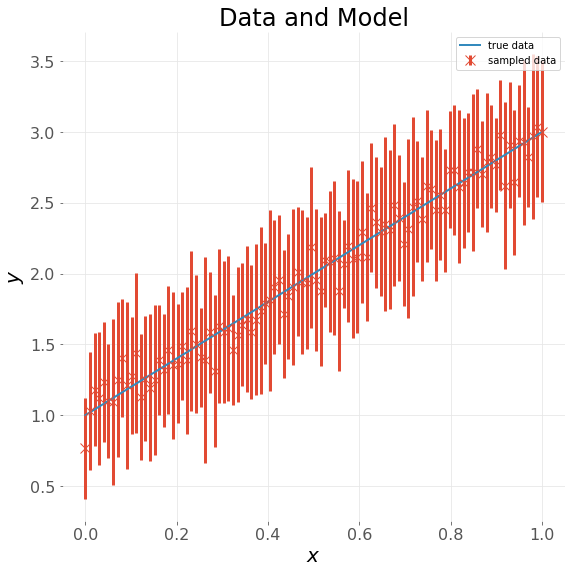

In [3]:
fig = plt.figure(figsize=(9,9))
ax  = fig.add_subplot(111, xlabel=r'$x$', ylabel=r'$y$', title = 'Data and Model')
ax.errorbar(x,y,yerr=dy,marker='x', ls='None', label='sampled data')
ax.plot(x, gold_line, label='true data', lw=2.0)
plt.legend(loc=0)
plt.show()

Bayes theorem states that ($X$ the vector of model parameters, $D$ the vector of measured data, and $I$ all the prior information)

$\begin{align}
P(X|D I) &\propto P(D|X I) P(X|I) \\
P(X|D I) &\propto P(D|X I)
\end{align}$

assuming uniform priors ($P(X|I) = \text{constant}$). Furthermore, since the individual datas are considered independent of eachother, subject to independent gaussian noise, we have

$\begin{align}
P(X | D I) &\propto \exp\left(-\frac{\chi^2}{2}\right) \\
\chi^2 &= \sum_k\left(\frac{y_k - Y_k}{\sigma_k}\right)^2
\end{align}$

where $y_k$ are the ideal (noiseless data, given the model parameters), whereas $Y_k$ are the measured noisy data values. The likelihood function is then given by

$\begin{align}
L &= \log{\left[P(X| D, I)\right]} = \text{constant} - \frac{\chi^2}{2} \\
\nabla L &= - \frac{1}{2}\nabla\chi^2
\end{align}$

So the most probable value, the one that maximizes the likelihood is the one that minimized $\chi^2$ (i.e., the least-square estimate), $\nabla \chi^2 = 0$

$\begin{align}
\chi^2 &= \sum_k \frac{\left(m x_k + c - Y_k\right)^2}{\sigma_k^2}\\
\partial_m \chi^2 &= \sum_k \frac{2 \left(m x_k + c - Y_k\right) x_k}{\sigma_k^2} \qquad
&\partial_c \chi^2 &= \sum_k \frac{2 \left(m x_k + c - Y_k\right)}{\sigma_k^2} \\
\nabla\chi^2 &= \begin{pmatrix}\partial_m \chi^2\\\partial_c \chi^2\end{pmatrix} = 
\begin{pmatrix}\sum w_k x_k^2 & \sum w_k x_k\\
\sum w_k x_k & \sum w_k
\end{pmatrix}\begin{pmatrix} m \\ c\end{pmatrix} - \begin{pmatrix}\sum w_k x_k Y_k\\
\sum w_k Y_k\end{pmatrix} \\
&=\begin{pmatrix}\alpha & \gamma \\\gamma &\beta\end{pmatrix}\begin{pmatrix}m \\ c\end{pmatrix} - \begin{pmatrix}p \\ q\end{pmatrix}
\end{align}$

with $w_k = 2/\sigma_k^2$. The optimum solution is then

$\begin{align}
\nabla \chi^2 &= 0 \\
\begin{pmatrix}m\\c\end{pmatrix} &=\begin{pmatrix}\alpha & \gamma\\\gamma &\beta\end{pmatrix}^{-1} \begin{pmatrix}p\\q\end{pmatrix} = \frac{1}{\alpha\beta - \gamma^2} \begin{pmatrix}\beta &-\gamma \\ -\gamma & \alpha\end{pmatrix}
\begin{pmatrix}p\\q\end{pmatrix} = \frac{1}{\alpha\beta-\gamma^2}\begin{pmatrix}
\beta p - \gamma q\\\alpha q - \gamma p
\end{pmatrix}
\end{align}$

Finally, the covariance matrix can be obtained from the Hessian $\boldsymbol{\sigma^2} = -(\nabla\nabla L)^{-1} = 2 (\nabla\nabla \chi^2)^{-1}$

$\begin{align}
\nabla\nabla \chi^2 &= \begin{pmatrix}\alpha & \gamma\\\gamma & \beta\end{pmatrix} \\
\boldsymbol{\sigma}^2 &= 2\frac{1}{\alpha\beta - \gamma^2}\begin{pmatrix}
\beta &-\gamma\\-\gamma & \alpha
\end{pmatrix}
\end{align}$

In [6]:
def optimal(xval, yval, yerr):
    w = 2 / yerr**2
    alpha,beta,gamma = np.sum(w*xval**2), np.sum(w), np.sum(w*xval)
    p,q  = np.sum(w*xval*yval), np.sum(w*yval)
    idet = 1.0 / (alpha*beta - gamma**2)
    m,c  = idet*(beta*p - gamma*q), idet*(alpha*q - gamma*p)
    return np.array([m,c]), 2*idet*np.array([[beta, -gamma], [-gamma, alpha]])
xopt, xcov = optimal(x, y, dy)
print('m_opt = {0:.3f} +/- {1:.3e}'.format(xopt[0], np.sqrt(xcov[0][0])))
print('c_opt = {0:.3f} +/- {1:.3e}'.format(xopt[1], np.sqrt(xcov[1][1])))

m_opt = 1.998 +/- 1.539e-01
c_opt = 0.999 +/- 8.982e-02


It corresponds to the numerical solution of course

In [8]:
def chi2(p):
    return np.sum((p[0]*x + p[1] - y)**2/dy**2)
opt = sp.optimize.minimize(chi2, [0, 0], method='BFGS', options={'maxiter':1000, 'disp':0})
print('m_opt = {0:.3f} +/- {1:.3e}'.format(opt['x'][0], np.sqrt(opt['hess_inv'][0][0]*2)))
print('c_opt = {0:.3f} +/- {1:.3e}'.format(opt['x'][1], np.sqrt(opt['hess_inv'][1][1]*2)))
opt

m_opt = 1.998 +/- 1.539e-01
c_opt = 0.999 +/- 8.982e-02


      fun: 4.9641087609772105
 hess_inv: array([[ 0.01184116, -0.00592663],
       [-0.00592663,  0.00403402]])
      jac: array([-2.86102295e-06,  4.70876694e-06])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([1.99848755, 0.99851067])

Alternatively, we can use MCMC to get the full distribution, not just the maximal likelihood 

In [9]:
with pm.Model() as model:
    #priors for unknown model parameters
    m = pm.Uniform('m', lower=0, upper=10)
    c = pm.Uniform('c', lower=0, upper=10)
    yobs = pm.Normal('yobs', mu=m*x + c, sd=dy, observed=y)
    trace = pm.sample(5000, tune = 10000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, m]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:12<00:00, 2315.57draws/s]


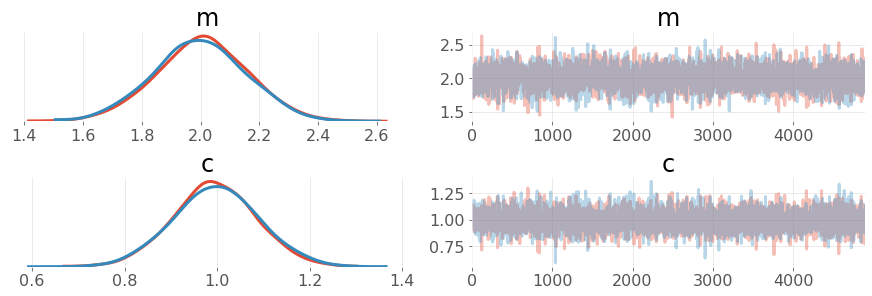

In [10]:
pm.traceplot(trace[100:]);

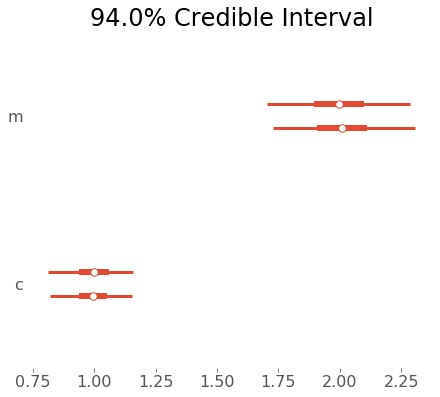

In [11]:
pm.forestplot(trace);

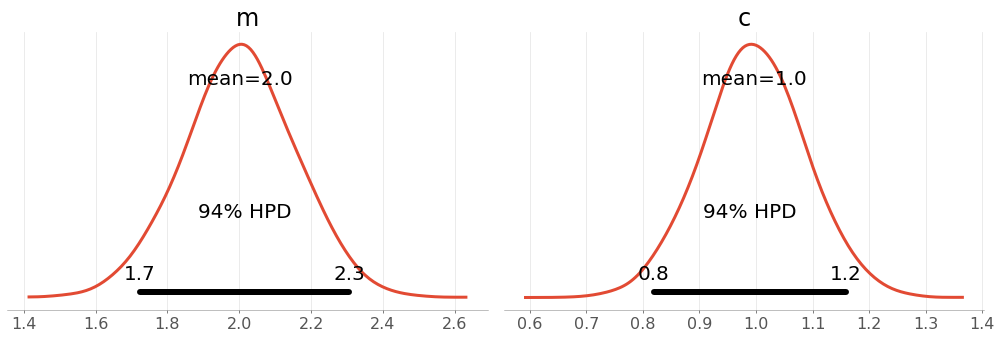

In [12]:
pm.plot_posterior(trace);

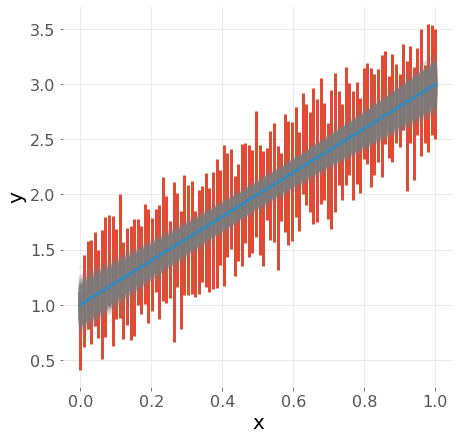

In [13]:
plt.figure(figsize=(7,7))
plt.errorbar(x, y, dy, ls='None', label='data')
niter = len(trace['m'])
for _m,_c in zip(trace['m'][niter//2::5], trace['c'][niter//2::5]):
    plt.plot(x, _m*x + _c, c='gray', alpha=0.1)
plt.plot(x, gold_line, label='true regression line', lw=3)
plt.xlabel('x')
plt.ylabel('y');